## Заглянем глубже: кластеризация методом k-средних
***Кластеризация*** - класс моделей машинного обучения без учителя.
Алгоритмы кластеризации нацелены на то, чтобы найти, исходя из свойств данных, оптимальное разбиение или дискретную маркировку групп точек.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # для стилизации графиков
import numpy as np

## Метод k-средних
Алгоритм *k-средних* выполняет поиск заранее заданного количества кластеров в немаркированном многомерном наборе данных. Достигается это с помощью простого представления о том, что такое оптимальная кластеризация.

• "Центр кластера" - арифметическое среднее всех точек, относящихся к этому кластеру.

• Каждая точка ближе к центру своего кластера, чем к центрам других кластеров.

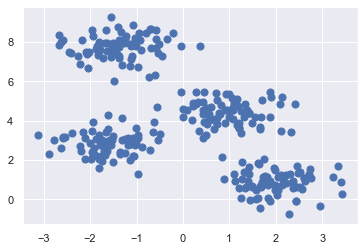

In [3]:
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

In [4]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

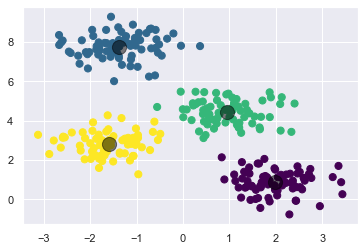

In [5]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

Черные точки - центры кластеров. Метод *k*-средних применяет алгоритм "*максимизация математического ожидания*".
## Алгоритм k-средних: максимизация математического ожидания (ЕМ)
Состоит он из следующей процедуры:
1. Выдвигаем гипотезу о центрах кластеров.
2. Повторяем до достижения сходимости:

    • *Е-шаг*: приписываем точки к ближайшим центрам кластеров;
    
    • *М-шаг*: задаем новые центры кластеров в соответствии со средними значенями.
    
Е-шаг или шаг ожидания (expectation), назват так потому, что включает актуализацию математического ожидания того, к каким кластерам относятся точки. М-шаг или шаг максимизации (maximization), назван так потому, что включает максимизацию некоторой целевой функции, описывающей расположение центров кластеров. В таком случае максимизация достигается путем простого усреднения данных в кластере. Визуализация ЕМ-алгоритма для метода *k*-средних:
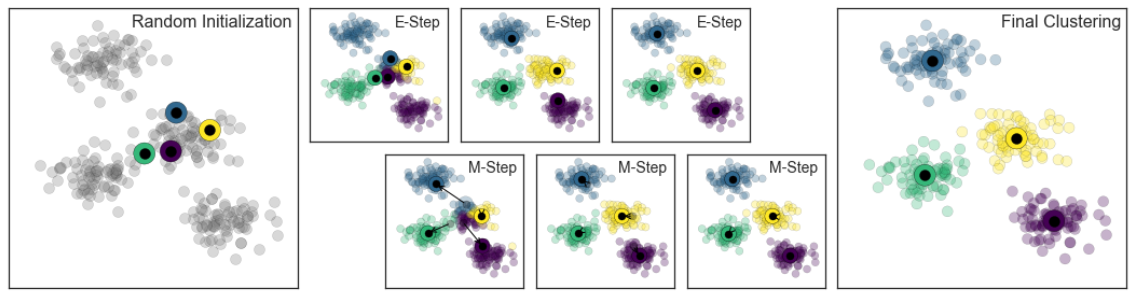

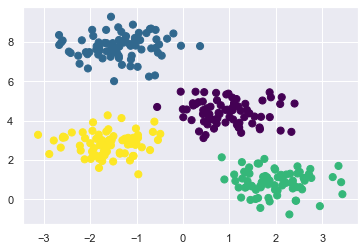

In [6]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Выбираем кластеры случайным образом
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Присваиваем метки в соответствии с ближайшим центром
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Находим новые центры, исходя из средних значений точек
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Проверяем сходимость
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

**Предупреждения относительно метода максимизации математического ожидания.** 

*Глобально оптимальный результат может оказаться недостижимым в принципе.* Во-первых, хотя процедура ЕМ гарантированно улучшает результат на каждом шаге, уверенности в том, что она ведет к *глобально* наилучшему решению, нет. Например, если мы воспользуемся в нашей простой процедуре другим начальным значением для генератора случайных чисел, полученные начальные гипотезы приведут к неудачным результатам:

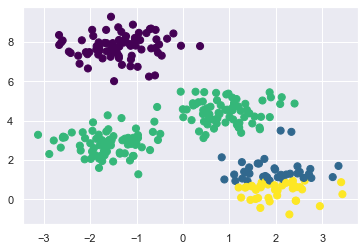

In [7]:
centers, labels = find_clusters(X, 4, rseed=0)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

В этом случае ЕМ-метод сошелся к глобально неоптимальной конфигурации, поэтому его часто выполняют для нескольких начальных гипотез.

*Количество кластеров следует выбирать заранее*. Еще одна часто встречающаяся проблема с методом *k*-средних заключается в том, что ему необходимо сообщить, какое кол-во кластеров вы ожидаете.

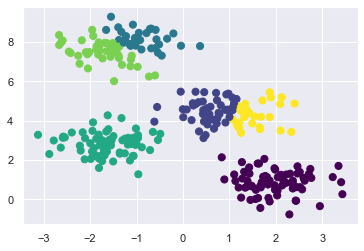

In [18]:
labels = KMeans(6, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

*Применение метода k-средних ограничивается случаем линейных границ кластеров.* Базовое допущение модели *k-средних* (точки должны быть ближе к центру их собственного кластера, чем других) означает, что этот алгоритм зачастую будет неэффективен в случае сложной геометрии кластеров.

В частности, границы между кластерами в методе *k-средних* всегда будут линейными, а значит, он будет плохо работать в случае более сложных границ.

In [19]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)

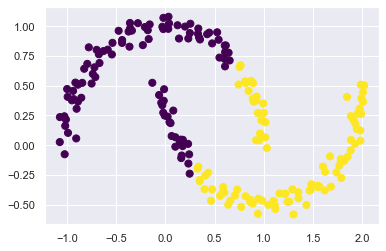

In [20]:
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

Чтобы исправить картину, мы можем воспользоваться ядерным преобразованием, чтобы метод *k*-средних стал распознавать нелинейные границы. Одна из версий этого ядерного метода *k*-средних реализована в библиотеке **Scikit-Learn** в оценивателе **SpectralClustering**. Она использует граф ближайших соседей для вычисления представления данных более высокой размерности, после чего задает соответствие меток с помощью алгоритма *k*-средних:

C:\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


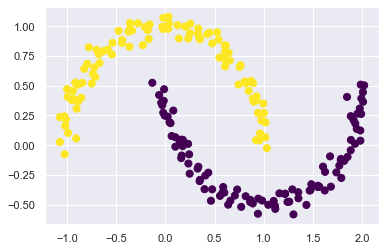

In [21]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

*Метод k-средних работает довольно медленно в случае большого количества выборок.* Например, можно применить лишь подмножество данных для корректировки центров кластеров на каждом шаге. Эта идея лежит в основе пакетных алгоритмов *k*-средних, один из которых реализован в классе **sklearn.cluster.MiniBatchKMeans**.
## Примеры
### Пример 1: применение метода k-средних для рукописных цифр
Попробуем воспользоваться методом *k*-средних для распознавания схожих цифр *без использования информации об исходных метках*.

In [22]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [23]:
# Кластеризация выполняется так же, как и ранее:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

В результате мы получили 10 кластеров в 64-мерном пространстве. Обратите внимание, что и центры кластеров представляют собой 64-мерные точки, а значит, их можно интерпретировать как "типичные" цифры в кластере. Посмотрим, что представляют собой эти центры кластеров:

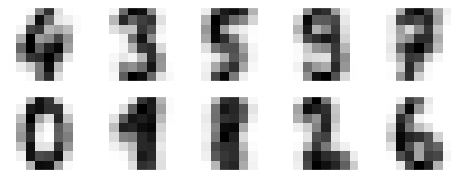

In [24]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

В силу того, что алгоритм *k*-средних ничего не знает о сущности кластеров, метки 0-9 могут оказаться перепутаны местами. Исправить это можно, задав соответствие всех полученных меток кластеров имеющимся в них фактическим меткам:

In [25]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

In [26]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7935447968836951

С помощью простого алгоритма *k*-средних мы определили правильную группировку для почти 80% исходных цифр! Посмотрим на матрицу различий:

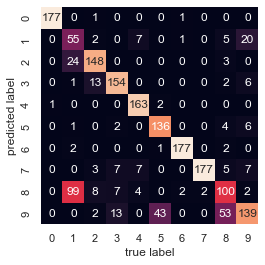

In [27]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

Воспользуемся для предварительной обработки данных до выполнения *k*-средних алгоритмом стохастического вложения соседей на основе распределения Стьюдента (t-SNE). ***t-SNE - нелинейный алгоритм вложения, особенно хорошо умеющий сохранять точки внутри кластеров.***

In [28]:
from sklearn.manifold import TSNE

# Проекция данных: выполнение этого шага займет несколько секунд
tsne = TSNE(n_components=2, init='random', random_state=0)
digits_proj = tsne.fit_transform(digits.data)

# Расчет кластеров
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj)

# Перестановка меток местами
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

# Оценка точности
accuracy_score(digits.target, labels)

C:\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


0.9432387312186978

Точность, даже *без использования меток*, составляет почти 95%. При разумном использовании алгоритмы машинного обучения без учителя демонстрируют отличные результаты: они могут извлекать информацию из набора данных даже тогда, когда сделать это вручную или визуально очень непросто.
### Пример 2: использование метода k-средних для сжатия цветов

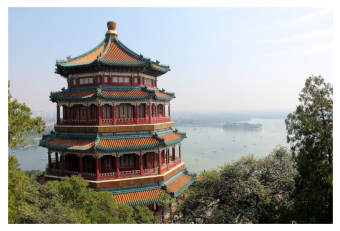

In [30]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china);

*Само изображение хранится в трехмерном массиве размера (высота, ширина, RGB), содержащем вклад в цвет по красному\синему\зеленому каналам в виде целочисленных значений от 0 до 255:*

In [32]:
china.shape

(427, 640, 3)

Этот набор пикселов можно рассматривать как облако точек в трехмерном цветовом пространстве. Изменим форму данных на [n_samples x n_features] и масштабируем шкалу цветов так, чтобы они располагались между 0 и 1:

In [33]:
data = china / 255.0 # use 0...1 scale
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

Визуализируем эти пикселы в данном цветовом пространстве, используя подмножество из 10000 пикселов для быстроты работы:

In [34]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # Выбираем случайное подмножество
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);


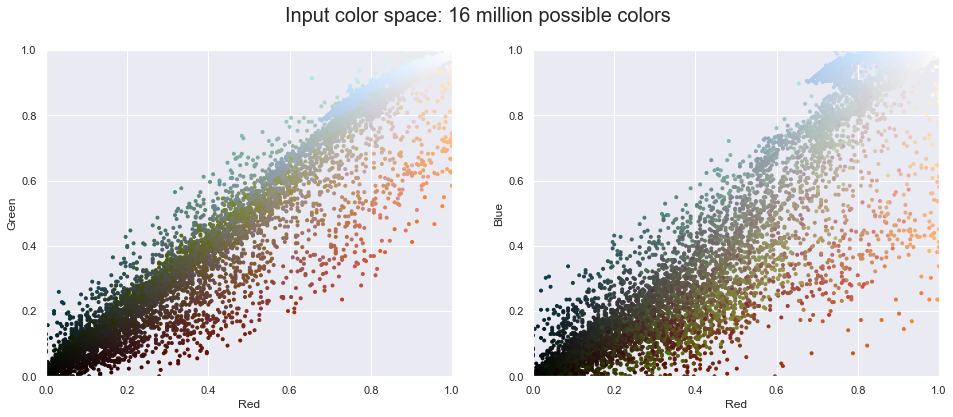

In [35]:
plot_pixels(data, title='Input color space: 16 million possible colors')

Теперь уменьшим количество цветов с 16 млн. до 16 путем кластеризации методом *k*-средних на пространстве пикселов:

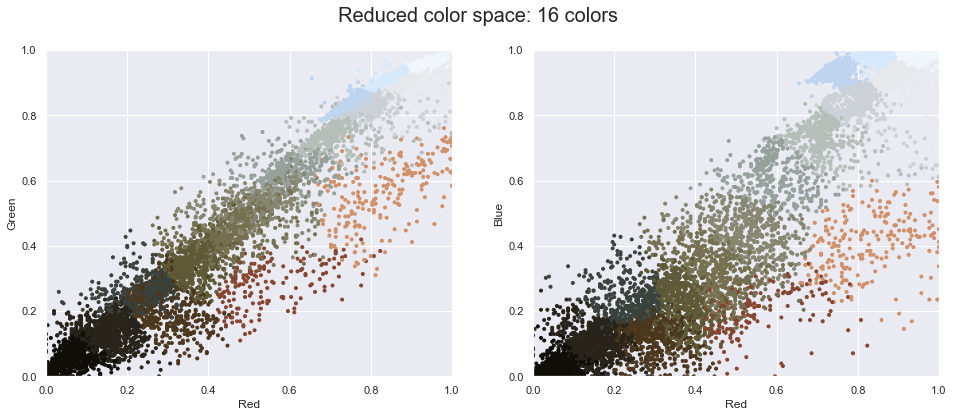

In [36]:
import warnings; warnings.simplefilter('ignore')  # Fix NumPy issues.

from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors,
            title="Reduced color space: 16 colors")

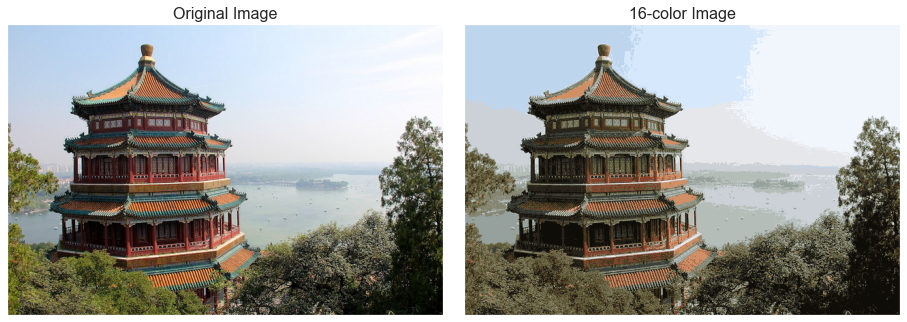

In [37]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16);

Коэффициент сжатия этого изображения - почти 1 млн.